### İmport Nesessary Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2024-04-05 20:23:32.225817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 20:23:32.434601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 20:23:33.362155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Define Function For Create Sample Data

In [2]:
def polynomial(x):
    y1 = x[:, 0] * x[:, 1] * x[:, 2] + 1.2 * x[:, 0] * x[:, 4] - 0.1 * x[:, 5] * x[:, 6] * x[:, 7] - 2 * x[:, 0]**2 * x[:, 7] + x[:, 4]
    y2 = x[:, 0] * x[:, 4] * x[:, 5] - x[:, 2] * x[:, 3] - 3 * x[:, 1] * x[:, 2] + 2 * x[:, 1]**2 * x[:, 3] - 2 * x[:, 6] * x[:, 7] - 1
    y3 = x[:, 2]**2 - x[:, 4] * x[:, 6] - 3 * x[:, 0] * x[:, 3] * x[:, 5] - x[:, 0]**2 * x[:, 2] * x[:, 4] - 1
    y4 = -x[:, 5]**3 + 2 * x[:, 0] * x[:, 2] * x[:, 7] - x[:, 0] * x[:, 3] * x[:, 6] - 2 * x[:, 4]**2 * x[:, 1] * x[:, 3] - x[:, 7]
    y5 = x[:, 0]**2 * x[:, 4] - 3 * x[:, 2] * x[:, 3] * x[:, 7] + x[:, 0] * x[:, 1] * x[:, 3] - 3 * x[:, 5] + x[:, 0]**2 * x[:, 6] + 2
    y6 = x[:, 0]**2 * x[:, 2] * x[:, 5] - x[:, 2] * x[:, 4] * x[:, 6] + x[:, 2] * x[:, 3] + 2.2 * x[:, 1] * x[:, 2]**2 - 1.1
    return np.stack([y1, y2, y3, y4, y5, y6], axis=-1)

In [3]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

### Create Sample Data

In [4]:
np.random.seed(0)
Nt = 1000
Nv = 100
noise_sigma = 0.001

print(tf.config.list_physical_devices('GPU'))

# Generate the input data
x_train = np.random.uniform(low=-1, high=1, size=(Nt, 8))
x_val = np.random.uniform(low=-1, high=1, size=(Nv, 8))

# Generate the output data with noise
y_train = polynomial(x_train) + np.random.normal(scale=noise_sigma)
y_val = polynomial(x_val)

[]


2024-04-05 20:23:34.380733: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: fedora
2024-04-05 20:23:34.380750: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: fedora
2024-04-05 20:23:34.380854: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-04-05 20:23:34.380880: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.67.0


### Some Functions -> Model Builder & With layer Node, Train Model With SGD

In [5]:
def build_model(hidden_layer_nodes, activation_fn):
    model = models.Sequential()
    model.add(layers.Dense(hidden_layer_nodes, activation=activation_fn))
    model.add(layers.Dense(hidden_layer_nodes, activation=activation_fn))
    model.add(layers.Dense(hidden_layer_nodes, activation=activation_fn))
    model.add(layers.Dense(6))
    return model

def build_model_with_nodes(hidden_layer1_nodes,hidden_layer2_nodes,hidden_layer3_nodes, activation_fn):
    model = models.Sequential()
    model.add(layers.Dense(hidden_layer1_nodes, activation=activation_fn))
    model.add(layers.Dense(hidden_layer2_nodes, activation=activation_fn))
    model.add(layers.Dense(hidden_layer3_nodes, activation=activation_fn))
    model.add(layers.Dense(6))
    return model

def train_model(model, x_train, y_train, x_val, y_val, learning_rate, epochs):
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    model.compile(optimizer=optimizer, loss=mse_loss, metrics=['mae'])
    history = model.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_data=(x_val, y_val), verbose=0)
    return history

### # Train the model with various configurations

In [6]:
# Train the model with various configurations
activations = ['relu', 'tanh', 'sigmoid']
learning_rates = [0.1, 0.01, 0.001]
epochs = [1000, 1500, 2250]

best_params = None
best_val_loss = 1.0  # set initial loss

for activation in activations:
    for learning_rate in learning_rates:
        for epoch in epochs:
            model = build_model(6, activation)
            history = train_model(model, x_train, y_train, x_val, y_val, learning_rate, epoch)
            print(
                f'\n - Activation:{activation}, Learning Rate:{learning_rate}, Epoch:{epoch} \n\tTraining and validation errors: {history.history["loss"][-1]:.4f}, {history.history["val_loss"][-1]:.4f}')

            val_loss = history.history["val_loss"][-1]
            if val_loss < best_val_loss:
                best_params = {'activation': activation, 'learning_rate': learning_rate, 'epoch': epoch}
                best_val_loss = val_loss

print(f'\nBest parameters: {best_params}')


 - Activation:relu, Learning Rate:0.1, Epoch:1000 
	Training and validation errors: 0.4011, 0.3978

 - Activation:relu, Learning Rate:0.1, Epoch:1500 
	Training and validation errors: 0.3909, 0.4184

 - Activation:relu, Learning Rate:0.1, Epoch:2250 
	Training and validation errors: 0.3910, 0.3949

 - Activation:relu, Learning Rate:0.01, Epoch:1000 
	Training and validation errors: 0.4390, 0.4497

 - Activation:relu, Learning Rate:0.01, Epoch:1500 
	Training and validation errors: 0.4249, 0.4308

 - Activation:relu, Learning Rate:0.01, Epoch:2250 
	Training and validation errors: 0.3598, 0.3215

 - Activation:relu, Learning Rate:0.001, Epoch:1000 
	Training and validation errors: 0.7043, 0.5791

 - Activation:relu, Learning Rate:0.001, Epoch:1500 
	Training and validation errors: 0.7106, 0.5698

 - Activation:relu, Learning Rate:0.001, Epoch:2250 
	Training and validation errors: 0.5208, 0.5069

 - Activation:tanh, Learning Rate:0.1, Epoch:1000 
	Training and validation errors: 0.3905

### Variance & Bias Curve

In [7]:
def plot_variance_bias_curve(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('M')
    plt.ylabel('Prediction Error')
    plt.xlabel('Complexity')
    plt.legend(['Training Samples', 'Test Samples'], loc='upper left')
    plt.show()

In [8]:
model1 = build_model_with_nodes(8, 6, 6, best_params.get("activation"))
history1 = train_model(model1, x_train, y_train, x_val, y_val, best_params.get("learning_rate"), best_params.get("epoch"))

model2 = build_model_with_nodes(6, 8, 6, best_params.get("activation"))
history2 = train_model(model2, x_train, y_train, x_val, y_val, best_params.get("learning_rate"), best_params.get("epoch"))

model3 = build_model_with_nodes(6, 6, 8, best_params.get("activation"))
history3 = train_model(model3, x_train, y_train, x_val, y_val, best_params.get("learning_rate"), best_params.get("epoch"))

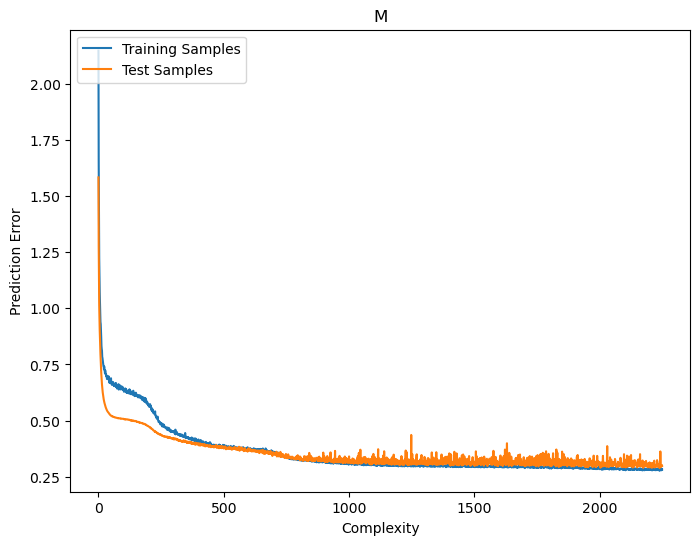

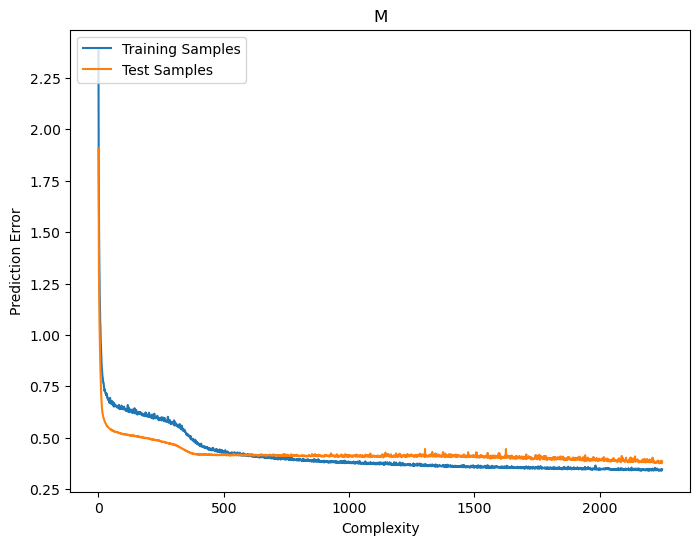

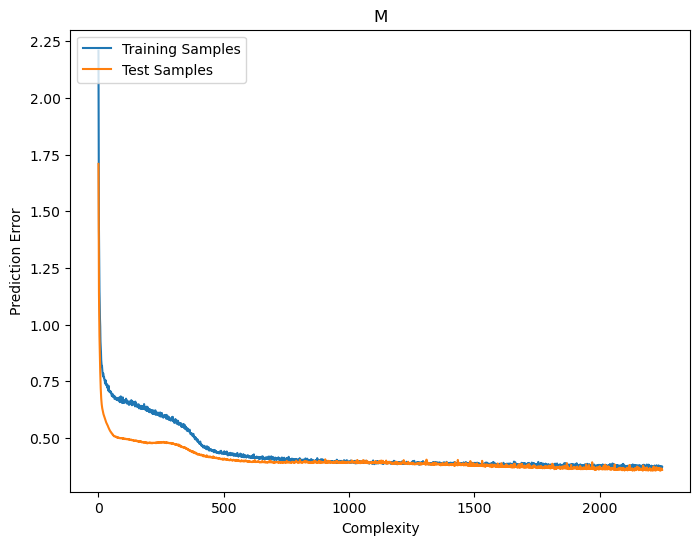

In [9]:
plot_variance_bias_curve(history1)
plot_variance_bias_curve(history2)
plot_variance_bias_curve(history3)

### Variance & Bias Curve With Add Some Nodes

In [10]:
Nt = 1100
Nv = 110
noise_sigma = 0.001

x_train = np.random.uniform(low=-1, high=1, size=(Nt, 8))
x_val = np.random.uniform(low=-1, high=1, size=(Nv, 8))

y_train = polynomial(x_train) + np.random.normal(scale=noise_sigma)
y_val = polynomial(x_val)


In [11]:
model1 = build_model_with_nodes(8, 6, 6, best_params.get("activation"))
history1 = train_model(model1, x_train, y_train, x_val, y_val, best_params.get("learning_rate"), best_params.get("epoch"))

model2 = build_model_with_nodes(6, 8, 6, best_params.get("activation"))
history2 = train_model(model2, x_train, y_train, x_val, y_val, best_params.get("learning_rate"), best_params.get("epoch"))

model3 = build_model_with_nodes(6, 6, 8, best_params.get("activation"))
history3 = train_model(model3, x_train, y_train, x_val, y_val, best_params.get("learning_rate"), best_params.get("epoch"))

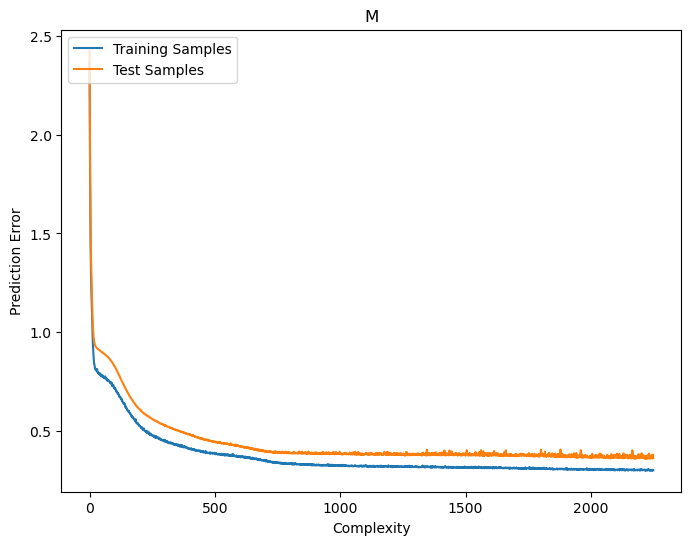

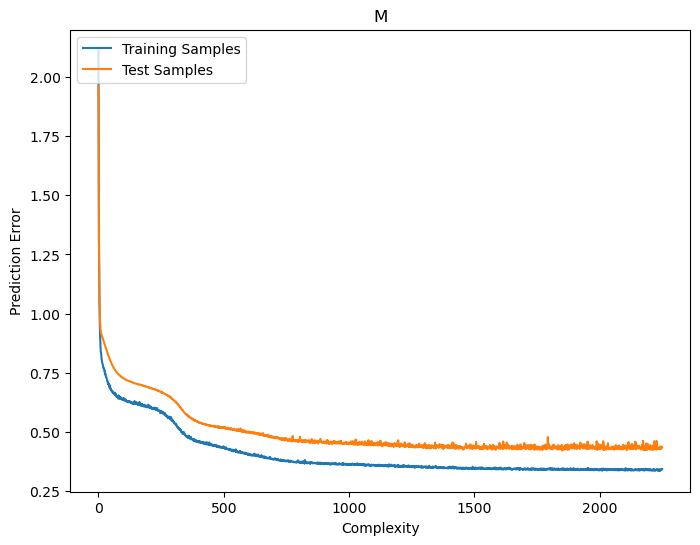

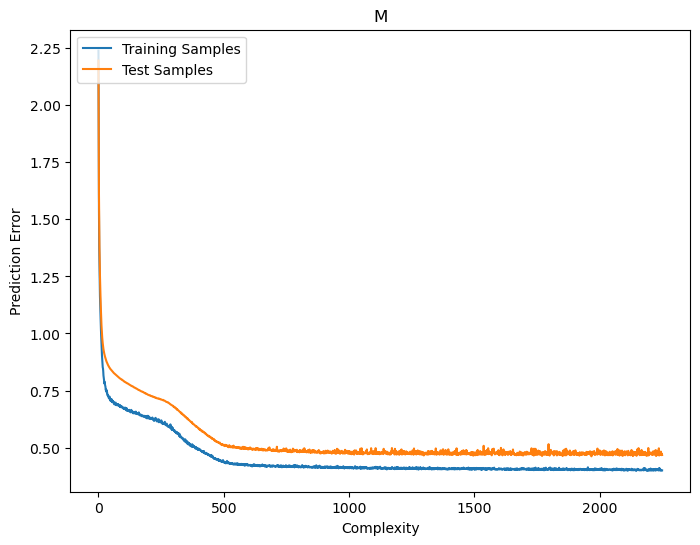

In [12]:
plot_variance_bias_curve(history1)
plot_variance_bias_curve(history2)
plot_variance_bias_curve(history3)